In [1]:
pip install requests wordcloud

# **Imports and preprocessing **

In [5]:
import requests
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

# Загрузка необходимых ресурсов NLTK (если еще не загружены)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker') # Для NER в NLTK
nltk.download('words') # Для NER в NLTK
nltk.download('tagsets') # Для help.upenn_tagset

# Загрузка spaCy модели
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spacy model 'en_core_web_sm'...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# URLs книг
book_urls = {
    'Alice\'s Adventures in Wonderland': 'https://www.gutenberg.org/files/11/11-0.txt',
    'Through the Looking-Glass': 'https://www.gutenberg.org/files/12/12-0.txt',
    'A Tangled Tale': 'https://www.gutenberg.org/cache/epub/29042/pg29042.txt'
}

# Корпус для хранения всех текстов
corpus = {}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


# 1. Function load_texts()

In [6]:
# 1. Функция load_texts()
def load_texts(urls_dict):
    cleaned_texts = {}
    for title, url in urls_dict.items():
        print(f"Loading '{title}' from {url}...")
        response = requests.get(url)
        # Убедимся, что кодировка правильная
        text = response.content.decode('utf-8')

        # Удаление не-слов (оставляем буквы, пробелы, некоторые знаки пунктуации для начала)
        # Более агрессивное удаление пунктуации будет на этапе токенизации
        # Удаляем символы, которые не являются буквой, пробелом, дефисом или апострофом
        # text = re.sub(r'[^a-zA-Z\s\'-]', '', text) # Это слишком агрессивно для начальной очистки

        cleaned_texts[title] = text
        print(f"'{title}' loaded.")
    return cleaned_texts

corpus_raw = load_texts(book_urls)

Loading 'Alice's Adventures in Wonderland' from https://www.gutenberg.org/files/11/11-0.txt...
'Alice's Adventures in Wonderland' loaded.
Loading 'Through the Looking-Glass' from https://www.gutenberg.org/files/12/12-0.txt...
'Through the Looking-Glass' loaded.
Loading 'A Tangled Tale' from https://www.gutenberg.org/cache/epub/29042/pg29042.txt...
'A Tangled Tale' loaded.


#2. Print the first 200 characters of each book

In [7]:
# 2. Печать первых 200 символов каждой книги
print("\n--- First 200 characters of each book (raw): ---")
for title, text in corpus_raw.items():
    print(f"\n'{title}':\n{text[:200]}...")


--- First 200 characters of each book (raw): ---

'Alice's Adventures in Wonderland':
*** START OF THE PROJECT GUTENBERG EBOOK 11 ***

[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Ho...

'Through the Looking-Glass':
*** START OF THE PROJECT GUTENBERG EBOOK 12 ***

[Illustration]




THROUGH THE LOOKING-GLASS

And What Alice Found There

By Lewis Carroll

The Millennium Fulcrum Edition 1.7




DRAMATIS PERSONÆ.
(_...

'A Tangled Tale':
﻿The Project Gutenberg eBook of A Tangled Tale
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
w...


# 3. Removing irrelevant parts of text (headers, Project Gutenberg footers)
# Use 'START OF THE PROJECT GUTENBERG EBOOK' and '*** END OF THE PROJECT GUTENBERG EBOOK'
# Or 'START' and '*** END' as specified in the hint

In [11]:
#var2
import re

# 3. Удаление нерелевантных частей текста (заголовки, футеры Project Gutenberg)
corpus_cleaned_refined = {}

for title, text in corpus_raw.items():
    cleaned_text = text

    # --- Шаг 1: Удаляем верхний заголовок Project Gutenberg ---
    # Ищем стандартный заголовок PG и все, что после него до первой пустой строки,
    # или до следующего "CHAPTER" / "Chapter" / "I." (для определения начала контента)
    # Это позволяет убрать "START OF THE PROJECT GUTENBERG EBOOK", ID и т.д.
    match_start = re.search(r'\*\*\* START OF THE PROJECT GUTENBERG EBOOK \d+ \*\*\*', cleaned_text)
    if match_start:
        cleaned_text = cleaned_text[match_start.end():] # Обрезаем все до конца маркера

    # Часто после этого маркера идут "Contents", "Illustrations", "DRAMATIS PERSONAE" и т.д.
    # Попробуем найти первое вхождение "CHAPTER" или "Chapter" или начало рассказа
    # Это более точный способ найти реальное начало книги.
    content_start_match = re.search(r'(CHAPTER\s+[IVXLCDM]+\.?|Chapter\s+\d+\.?|I\.\s+\S+)', cleaned_text, re.IGNORECASE)
    if content_start_match:
        # Если нашли главу, начинаем текст с нее
        cleaned_text = cleaned_text[content_start_match.start():]
    else:
        # Если не нашли главы (как в Tangled Tale, или очень короткая книга без глав),
        # пробуем найти другие общие начала или просто отрезать первые несколько строк/абзацев.
        # Для A Tangled Tale, которая начиналась с "A TANGLED TALE ***",
        # можно искать это и обрезать до следующей значащей строки.
        # Это более сложный случай, и для него можно сделать специфичное правило.
        if "A Tangled Tale" in title:
            # Специфичное правило для "A Tangled Tale"
            # Пропускаем первые несколько строк, содержащих информацию о продюсерах и т.д.
            # Можно искать конец "Transcriber's note" или "Produced by"
            tangled_start_match = re.search(r'(?i)(Transcriber\'s note|Produced by.+?)(?:\r?\n){2,}', cleaned_text)
            if tangled_start_match:
                cleaned_text = cleaned_text[tangled_start_match.end():].strip()
            else:
                # Если специфичный маркер не найден, просто отрезаем первые 10-15 строк
                # как грубый, но рабочий метод для этой книги.
                lines = cleaned_text.splitlines()
                if len(lines) > 20: # Пропускаем первые 20 строк, если их достаточно
                    cleaned_text = '\n'.join(lines[20:])
                else: # Или меньше, если книга короткая
                    cleaned_text = '\n'.join(lines[5:])
                cleaned_text = cleaned_text.strip()


    # --- Шаг 2: Удаляем нижний футер Project Gutenberg ---
    # Ищем стандартный футер
    match_end = re.search(r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK \d+ \*\*\*', cleaned_text)
    if match_end:
        cleaned_text = cleaned_text[:match_end.start()].strip() # Обрезаем все после маркера

    # Ищем другие варианты конца или просто отрезаем последние 200 символов,
    # если там явно "END OF...", "E-text of..." и т.д.
    match_end_general = re.search(r'(?i)(End of the Project Gutenberg EBook|E-text of|The End)', cleaned_text[-500:])
    if match_end_general:
        cleaned_text = cleaned_text[:len(cleaned_text)-500+match_end_general.start()].strip()

    # Удаляем лишние переводы строк и множественные пробелы
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    corpus_cleaned_refined[title] = cleaned_text

print("\n--- First 200 characters of each book (after refined cleaning): ---")
for title, text in corpus_cleaned_refined.items():
    print(f"\n'{title}':\n{text[:200]}...")
print("-" * 30)


--- First 200 characters of each book (after refined cleaning): ---

'Alice's Adventures in Wonderland':
CHAPTER I. Down the Rabbit-Hole CHAPTER II. The Pool of Tears CHAPTER III. A Caucus-Race and a Long Tale CHAPTER IV. The Rabbit Sends in a Little Bill CHAPTER V. Advice from a Caterpillar CHAPTER VI. ...

'Through the Looking-Glass':
CHAPTER I. Looking-Glass house CHAPTER II. The Garden of Live Flowers CHAPTER III. Looking-Glass Insects CHAPTER IV. Tweedledum And Tweedledee CHAPTER V. Wool and Water CHAPTER VI. Humpty Dumpty CHAPT...

'A Tangled Tale':
i. *** START OF THE PROJECT GUTENBERG EBOOK A TANGLED TALE *** Produced by Chris Curnow, Carla Foust, Lindy Walsh and the Online Distributed Proofreading Team at https://www.pgdp.net. Music transcribe...
------------------------------


In [8]:
#var1
# 3. Удаление нерелевантных частей текста (заголовки, футеры Project Gutenberg)
# Используем 'START OF THE PROJECT GUTENBERG EBOOK' и '*** END OF THE PROJECT GUTENBERG EBOOK'
# Или 'START' и '*** END' как указано в хинте

corpus_cleaned_start_end = {}
for title, text in corpus_raw.items():
    # Находим индексы начала и конца релевантного текста
    start_phrase = 'START OF THE PROJECT GUTENBERG EBOOK'
    end_phrase = '*** END OF THE PROJECT GUTENBERG EBOOK'

    # Можно использовать более общий 'START' и '*** END' как в хинте,
    # но полные фразы Project Gutenberg обычно надежнее.
    # Если их нет, пробуем 'START' и '*** END'
    start_index = text.find(start_phrase)
    if start_index == -1:
        start_index = text.find('*** START')
        if start_index == -1:
             start_index = 0 # Fallback if specific phrases not found

    end_index = text.find(end_phrase)
    if end_index == -1:
        end_index = text.find('*** END')
        if end_index == -1:
            end_index = len(text) # Fallback if specific phrases not found

    # Обрезаем текст
    # Добавляем длину фразы, чтобы начать текст сразу после нее
    if start_index != 0:
        cleaned_text = text[start_index + len(start_phrase):end_index].strip()
    else: # If start phrase not found, assume relevant text starts from beginning
        cleaned_text = text[start_index:end_index].strip()

    # Удаляем лишние переводы строк и множественные пробелы
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    corpus_cleaned_start_end[title] = cleaned_text

print("\n--- First 200 characters of each book (after start/end cleaning): ---")
for title, text in corpus_cleaned_start_end.items():
    print(f"\n'{title}':\n{text[:200]}...")
print("-" * 30)


--- First 200 characters of each book (after start/end cleaning): ---

'Alice's Adventures in Wonderland':
11 *** [Illustration] Alice’s Adventures in Wonderland by Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 Contents CHAPTER I. Down the Rabbit-Hole CHAPTER II. The Pool of Tears CHAPTER III. A Caucus-...

'Through the Looking-Glass':
12 *** [Illustration] THROUGH THE LOOKING-GLASS And What Alice Found There By Lewis Carroll The Millennium Fulcrum Edition 1.7 DRAMATIS PERSONÆ. (_As arranged before commencement of game._) WHITE RED....

'A Tangled Tale':
A TANGLED TALE *** Produced by Chris Curnow, Carla Foust, Lindy Walsh and the Online Distributed Proofreading Team at https://www.pgdp.net. Music transcribed by Linda Cantoni. Transcriber's note Minor...
------------------------------


In [12]:
#var3
import re

# 3. Удаление нерелевантных частей текста (заголовки, футеры Project Gutenberg)
corpus_cleaned_refined = {}

for title, text in corpus_raw.items():
    cleaned_text = text

    # --- Шаг 1: Удаляем верхний заголовок Project Gutenberg ---
    # Общий маркер начала книги Project Gutenberg
    match_start_pg_header = re.search(r'\*\*\* START OF THE PROJECT GUTENBERG EBOOK \d+ \*\*\*', cleaned_text)
    if match_start_pg_header:
        cleaned_text = cleaned_text[match_start_pg_header.end():] # Обрезаем все до конца маркера

    # Специфическая логика для "A Tangled Tale", если она еще содержит PG-заголовок
    if "A Tangled Tale" in title:
        # Ищем специфический маркер для этой книги
        tangled_pg_start = re.search(r'\*\*\* START OF THE PROJECT GUTENBERG EBOOK A TANGLED TALE \*\*\*', cleaned_text)
        if tangled_pg_start:
            cleaned_text = cleaned_text[tangled_pg_start.end():] # Обрезаем до конца этого специфического маркера

        # Теперь пытаемся найти конец метаданных "Produced by..."
        # Ищем следующую пустую строку или несколько пустых строк после "Produced by..."
        # (?s) позволяет . соответствовать переводам строк
        tangled_meta_end_match = re.search(r'(?si)(Produced by.+?)(?:\r?\n){3,}', cleaned_text)
        if tangled_meta_end_match:
            cleaned_text = cleaned_text[tangled_meta_end_match.end():].strip()
        else:
            # Если не найдено, попробуем более простое отсечение первых N строк,
            # но только если это кажется безопасным (т.е. не отсечем важный контент)
            lines = cleaned_text.splitlines()
            # Пропускаем строки, которые выглядят как метаданные
            # Это эвристика, может потребовать точной настройки
            processed_lines = []
            skip = True
            for line in lines:
                if skip:
                    # Пропускаем, пока не встретим что-то похожее на начало контента
                    # или пока не закончатся типичные метаданные
                    if not re.search(r'(?i)(produced by|transcriber|music transcribed|online distributed proofreading team|contents|chapter\s+[ivxcdm0-9]+|\.\.\.)', line) and line.strip():
                        skip = False
                if not skip:
                    processed_lines.append(line)
            cleaned_text = '\n'.join(processed_lines).strip()

    # Общая логика для поиска начала контента (главы)
    content_start_match = re.search(r'(CHAPTER\s+[IVXLCDM]+\.?|Chapter\s+\d+\.?|I\.\s+\S+)', cleaned_text, re.IGNORECASE)
    if content_start_match:
        cleaned_text = cleaned_text[content_start_match.start():]

    # --- Шаг 2: Удаляем нижний футер Project Gutenberg ---
    match_end_pg_footer = re.search(r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK \d+ \*\*\*', cleaned_text)
    if match_end_pg_footer:
        cleaned_text = cleaned_text[:match_end_pg_footer.start()].strip()

    # Более общий поиск конца книги
    match_end_general = re.search(r'(?i)(End of the Project Gutenberg EBook|E-text of|The End|Project Gutenberg-tm EBooks are)', cleaned_text[-1000:])
    if match_end_general:
        cleaned_text = cleaned_text[:len(cleaned_text)-1000+match_end_general.start()].strip()

    # Удаляем лишние переводы строк и множественные пробелы
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    corpus_cleaned_refined[title] = cleaned_text

print("\n--- First 200 characters of each book (after refined cleaning): ---")
for title, text in corpus_cleaned_refined.items():
    print(f"\n'{title}':\n{text[:200]}...")
print("-" * 30)


--- First 200 characters of each book (after refined cleaning): ---

'Alice's Adventures in Wonderland':
CHAPTER I. Down the Rabbit-Hole CHAPTER II. The Pool of Tears CHAPTER III. A Caucus-Race and a Long Tale CHAPTER IV. The Rabbit Sends in a Little Bill CHAPTER V. Advice from a Caterpillar CHAPTER VI. ...

'Through the Looking-Glass':
CHAPTER I. Looking-Glass house CHAPTER II. The Garden of Live Flowers CHAPTER III. Looking-Glass Insects CHAPTER IV. Tweedledum And Tweedledee CHAPTER V. Wool and Water CHAPTER VI. Humpty Dumpty CHAPT...

'A Tangled Tale':
I. EXCELSIOR 1 II. ELIGIBLE APARTMENTS 4 III. MAD MATHESIS 13 IV. THE DEAD RECKONING 19 V. OUGHTS AND CROSSES 27 VI. HER RADIANCY 34 VII. PETTY CASH 43 VIII. DE OMNIBUS REBUS 52 IX. A SERPENT WITH COR...
------------------------------


SUM
To achieve a cleaner result, especially when dealing with non-standard cases like "A Tangled Tale", sometimes you have to resort to a more "hardcoded" or, more accurately, more specific and manual approach. Option 3 showed the best result

#4. Tokenize the text and print the first 150 tokens

In [14]:
# 4. Токенизация текста и печать первых 150 токенов
import nltk
nltk.download('punkt_tab')
corpus_tokenized = {}
for title, text in corpus_cleaned_start_end.items():
    # Токенизация и приведение к нижнему регистру
    tokens = word_tokenize(text.lower())
    # Дополнительно очищаем от пунктуации, оставляя только алфавитные токены
    tokens = [word for word in tokens if word.isalpha()]
    corpus_tokenized[title] = tokens

print("\n--- First 150 tokens of each book (after tokenization and lowercasing): ---")
for title, tokens in corpus_tokenized.items():
    print(f"\n'{title}':\n{tokens[:150]}...")
print("-" * 30)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



--- First 150 tokens of each book (after tokenization and lowercasing): ---

'Alice's Adventures in Wonderland':
['illustration', 'alice', 's', 'adventures', 'in', 'wonderland', 'by', 'lewis', 'carroll', 'the', 'millennium', 'fulcrum', 'edition', 'contents', 'chapter', 'down', 'the', 'chapter', 'ii', 'the', 'pool', 'of', 'tears', 'chapter', 'iii', 'a', 'and', 'a', 'long', 'tale', 'chapter', 'iv', 'the', 'rabbit', 'sends', 'in', 'a', 'little', 'bill', 'chapter', 'advice', 'from', 'a', 'caterpillar', 'chapter', 'vi', 'pig', 'and', 'pepper', 'chapter', 'vii', 'a', 'mad', 'chapter', 'viii', 'the', 'queen', 's', 'chapter', 'ix', 'the', 'mock', 'turtle', 's', 'story', 'chapter', 'the', 'lobster', 'quadrille', 'chapter', 'xi', 'who', 'stole', 'the', 'tarts', 'chapter', 'xii', 'alice', 's', 'evidence', 'chapter', 'down', 'the', 'alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank', 'and', 'of', 'having', 'nothing', 'to', 'do', '

# 5. Removing stop words

In [15]:
# 5. Удаление стоп-слов
stop_words = set(stopwords.words('english'))
corpus_no_stopwords = {}
for title, tokens in corpus_tokenized.items():
    filtered_tokens = [word for word in tokens if word not in stop_words]
    corpus_no_stopwords[title] = filtered_tokens

print("\n--- Checking stop-words removal (example: 'i', 'me', 'my', 'the'): ---")
for title, tokens in corpus_tokenized.items():
    # Проверяем в оригинальных токенах
    original_counts = Counter(tokens)
    print(f"\n'{title}' (Original Tokens):")
    print(f"  'i': {original_counts['i']}, 'me': {original_counts['me']}, 'the': {original_counts['the']}")

    # Проверяем в токенах без стоп-слов
    filtered_counts = Counter(corpus_no_stopwords[title])
    print(f"'{title}' (No Stopwords Tokens):")
    print(f"  'i': {filtered_counts['i']}, 'me': {filtered_counts['me']}, 'the': {filtered_counts['the']}")
print("-" * 30)


--- Checking stop-words removal (example: 'i', 'me', 'my', 'the'): ---

'Alice's Adventures in Wonderland' (Original Tokens):
  'i': 510, 'me': 63, 'the': 1638
'Alice's Adventures in Wonderland' (No Stopwords Tokens):
  'i': 0, 'me': 0, 'the': 0

'Through the Looking-Glass' (Original Tokens):
  'i': 622, 'me': 84, 'the': 1587
'Through the Looking-Glass' (No Stopwords Tokens):
  'i': 0, 'me': 0, 'the': 0

'A Tangled Tale' (Original Tokens):
  'i': 344, 'me': 49, 'the': 1734
'A Tangled Tale' (No Stopwords Tokens):
  'i': 0, 'me': 0, 'the': 0
------------------------------


# 6. Stemming (PorterStemmer)

In [16]:
# 6. Стемминг (PorterStemmer)
porter_stemmer = PorterStemmer()
corpus_stemmed = {}
print("\n--- First 50 stemmed tokens of each book: ---")
for title, tokens in corpus_no_stopwords.items(): # Стеммим уже очищенные от стоп-слов токены
    stemmed_tokens = [porter_stemmer.stem(word) for word in tokens]
    corpus_stemmed[title] = stemmed_tokens
    print(f"\n'{title}':\n{stemmed_tokens[:50]}...")
print("-" * 30)


--- First 50 stemmed tokens of each book: ---

'Alice's Adventures in Wonderland':
['illustr', 'alic', 'adventur', 'wonderland', 'lewi', 'carrol', 'millennium', 'fulcrum', 'edit', 'content', 'chapter', 'chapter', 'ii', 'pool', 'tear', 'chapter', 'iii', 'long', 'tale', 'chapter', 'iv', 'rabbit', 'send', 'littl', 'bill', 'chapter', 'advic', 'caterpillar', 'chapter', 'vi', 'pig', 'pepper', 'chapter', 'vii', 'mad', 'chapter', 'viii', 'queen', 'chapter', 'ix', 'mock', 'turtl', 'stori', 'chapter', 'lobster', 'quadril', 'chapter', 'xi', 'stole', 'tart']...

'Through the Looking-Glass':
['illustr', 'alic', 'found', 'lewi', 'carrol', 'millennium', 'fulcrum', 'edit', 'dramati', 'personæ', 'arrang', 'commenc', 'white', 'red', 'piec', 'pawn', 'pawn', 'piec', 'tweedlede', 'daisi', 'daisi', 'humpti', 'dumpti', 'unicorn', 'haigha', 'messeng', 'carpent', 'sheep', 'oyster', 'oyster', 'walru', 'queen', 'queen', 'king', 'fawn', 'rose', 'king', 'age', 'man', 'oyster', 'oyster', 'crow', 'knight', 'hatta',

#7. Lemmatization (spaCy)

In [17]:
# 7. Лемматизация (spaCy)
# Для лемматизации spacy нужна строка, а не список токенов, чтобы сохранить контекст для более точной лемматизации
# Поэтому берем текст после очистки начала/конца, но до токенизации и удаления стоп-слов
corpus_lemmatized_spacy = {}
print("\n--- First 50 lemmatized tokens of each book (using spaCy): ---")
for title, text in corpus_cleaned_start_end.items():
    doc = nlp(text.lower()) # Приводим к нижнему регистру перед спаси
    # Извлекаем леммы, фильтруя неалфавитные символы и стоп-слова
    lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words]
    corpus_lemmatized_spacy[title] = lemmatized_tokens
    print(f"\n'{title}':\n{lemmatized_tokens[:50]}...")
print("-" * 30)



--- First 50 lemmatized tokens of each book (using spaCy): ---

'Alice's Adventures in Wonderland':
['illustration', 'alice', 'adventure', 'wonderland', 'lewis', 'carroll', 'millennium', 'fulcrum', 'edition', 'content', 'chapter', 'rabbit', 'hole', 'chapter', 'ii', 'pool', 'tears', 'chapter', 'iii', 'caucus', 'race', 'long', 'tale', 'chapter', 'iv', 'rabbit', 'send', 'little', 'bill', 'chapter', 'advice', 'caterpillar', 'chapter', 'vi', 'pig', 'pepper', 'chapter', 'vii', 'mad', 'tea', 'party', 'chapter', 'viii', 'queen', 'croquet', 'ground', 'chapter', 'ix', 'mock', 'turtle']...

'Through the Looking-Glass':
['illustration', 'look', 'glass', 'alice', 'find', 'lewis', 'carroll', 'millennium', 'fulcrum', 'edition', 'dramatis', 'personæ', 'arrange', 'commencement', 'game', 'white', 'red', 'piece', 'pawn', 'pawn', 'piece', 'tweedledee', 'daisy', 'daisy', 'humpty', 'dumpty', 'unicorn', 'haigha', 'messenger', 'carpenter', 'sheep', 'oyster', 'oyster', 'walrus', 'queen', 'lily', 'tiger', 'lil

# 8. Analysis of the differences between stemming and lemmatization

In [19]:
# 8. Анализ различий между стеммингом и лемматизацией
print("\n--- Анализ различий между стеммингом и лемматизацией: ---")
for title in corpus_stemmed.keys():
    print(f"\n'{title}':")
    print("  Стемминг (пример):", corpus_stemmed[title][0:10])
    print("  Лемматизация (пример):", corpus_lemmatized_spacy[title][0:10])
    print("\n  **Различия и Почему:**")
    print("  - **Стемминг (PorterStemmer):** Это более 'грубый' и быстрый процесс. Он просто отсекает суффиксы слов, чтобы получить их 'корень' (stem), который часто не является настоящим словом. Например, 'running' -> 'run', 'cities' -> 'citi'. Он работает по набору эвристических правил.")
    print("  - **Лемматизация (spaCy):** Это более 'интеллектуальный' и точный процесс. Она использует морфологический анализ и словарь языка, чтобы привести слово к его базовой словарной форме (лемме). Например, 'running' -> 'run', 'ran' -> 'run', 'better' -> 'good', 'cities' -> 'city'. Лемматизация учитывает часть речи и контекст (хотя в нашем случае мы подаем по словам, spaCy имеет встроенные механизмы).")
    print("  - **Почему разные:** Лемматизация стремится вернуть *существующее слово*, в то время как стемминг просто обрезает суффиксы, что может привести к несуществующим словам. Лемматизация обычно предпочтительнее для задач, где требуется точное понимание смысла слова (например, для построения эмбеддингов, NER, POS-теггинга), тогда как стемминг может быть достаточен для задач, где важна только схожесть корней (например, для информационного поиска, где важен факт наличия корня слова).")
print("-" * 30)


--- Анализ различий между стеммингом и лемматизацией: ---

'Alice's Adventures in Wonderland':
  Стемминг (пример): ['illustr', 'alic', 'adventur', 'wonderland', 'lewi', 'carrol', 'millennium', 'fulcrum', 'edit', 'content']
  Лемматизация (пример): ['illustration', 'alice', 'adventure', 'wonderland', 'lewis', 'carroll', 'millennium', 'fulcrum', 'edition', 'content']

  **Различия и Почему:**
  - **Стемминг (PorterStemmer):** Это более 'грубый' и быстрый процесс. Он просто отсекает суффиксы слов, чтобы получить их 'корень' (stem), который часто не является настоящим словом. Например, 'running' -> 'run', 'cities' -> 'citi'. Он работает по набору эвристических правил.
  - **Лемматизация (spaCy):** Это более 'интеллектуальный' и точный процесс. Она использует морфологический анализ и словарь языка, чтобы привести слово к его базовой словарной форме (лемме). Например, 'running' -> 'run', 'ran' -> 'run', 'better' -> 'good', 'cities' -> 'city'. Лемматизация учитывает часть речи и контекст (х

# 9. POS tagging (NLTK)

In [21]:
# 9. POS-тегирование (NLTK)
# Для POS-тегирования NLTK лучше использовать токены, близкие к исходным (но lowercase)
# Или токены после удаления стоп-слов, если это соответствует задаче.
# Используем токены без стоп-слов, как они уже прошли базовую очистку
import nltk
nltk.download('averaged_perceptron_tagger_eng')
corpus_pos_tagged = {}
print("\n--- POS Tags for each book (first 20 tags from tokens without stopwords): ---")
for title, tokens in corpus_no_stopwords.items():
    pos_tags = nltk.pos_tag(tokens)
    corpus_pos_tagged[title] = pos_tags
    print(f"\n'{title}':\n{pos_tags[:20]}...")
print("-" * 30)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.



--- POS Tags for each book (first 20 tags from tokens without stopwords): ---

'Alice's Adventures in Wonderland':
[('illustration', 'NN'), ('alice', 'NN'), ('adventures', 'NNS'), ('wonderland', 'VBP'), ('lewis', 'JJ'), ('carroll', 'NN'), ('millennium', 'NN'), ('fulcrum', 'NN'), ('edition', 'NN'), ('contents', 'NNS'), ('chapter', 'NN'), ('chapter', 'NN'), ('ii', 'JJ'), ('pool', 'NN'), ('tears', 'NNS'), ('chapter', 'NN'), ('iii', 'VBP'), ('long', 'JJ'), ('tale', 'NN'), ('chapter', 'NN')]...

'Through the Looking-Glass':
[('illustration', 'NN'), ('alice', 'NN'), ('found', 'VBD'), ('lewis', 'JJ'), ('carroll', 'NN'), ('millennium', 'NN'), ('fulcrum', 'NN'), ('edition', 'NN'), ('dramatis', 'NN'), ('personæ', 'NN'), ('arranged', 'VBD'), ('commencement', 'JJ'), ('white', 'JJ'), ('red', 'JJ'), ('pieces', 'NNS'), ('pawns', 'VBP'), ('pawns', 'NNS'), ('pieces', 'NNS'), ('tweedledee', 'VBP'), ('daisy', 'JJ')]...

'A Tangled Tale':
[('tangled', 'VBN'), ('tale', 'NN'), ('produced', 'VBN'), ('chris'

# 10. NER (NLTK)

In [26]:
# 10. NER (NLTK)
# NLTK NER требует NLTK chunking, который работает с POS-тегами.
# Для NLTK NER часто нужны более полные данные (без агрессивной предобработки)
# Попробуем на токенах, очищенных от пунктуации и приведенных к нижнему регистру (corpus_tokenized)
# NLTK NER не так мощен, как SpaCy, и часто требует дополнительной предварительной обработки (chunking)
# и тренировки, чтобы быть эффективным. Но попробуем базовый вариант.
from nltk.chunk import ne_chunk
import nltk
nltk.download('maxent_ne_chunker') # Добавь эту строку
nltk.download('words') # Добавь эту строку, если не было
nltk.download('maxent_ne_chunker_tab')

corpus_ner_nltk = {}
print("\n--- Named Entities (NLTK) for each book (first 5 entities detected): ---")
for title, tokens in corpus_tokenized.items(): # Используем токены после базовой токенизации и очистки от пунктуации
    pos_tags = nltk.pos_tag(tokens)
    named_entities = []
    for chunk in ne_chunk(pos_tags):
        if hasattr(chunk, 'label'):
            named_entities.append((chunk.label(), ' '.join(c[0] for c in chunk)))
    corpus_ner_nltk[title] = named_entities
    print(f"\n'{title}':\n{named_entities[:5]}...")

print("\n**Замечание по NER (NLTK):**")
print("  NLTK NER зачастую менее точен и менее гибок, чем spaCy, и требует более специфичной предобработки или дополнительного обучения для хороших результатов.")
print("  Вы можете заметить, что spaCy (которую мы использовали ранее) дает более качественные результаты для NER, поскольку она обучена на больших корпусах с использованием современных архитектур.")
print("-" * 30)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.



--- Named Entities (NLTK) for each book (first 5 entities detected): ---

'Alice's Adventures in Wonderland':
[]...

'Through the Looking-Glass':
[]...

'A Tangled Tale':
[]...

**Замечание по NER (NLTK):**
  NLTK NER зачастую менее точен и менее гибок, чем spaCy, и требует более специфичной предобработки или дополнительного обучения для хороших результатов.
  Вы можете заметить, что spaCy (которую мы использовали ранее) дает более качественные результаты для NER, поскольку она обучена на больших корпусах с использованием современных архитектур.
------------------------------


# **Analysing the text**

1. Word Cloud Display

We use lemmatized text (or without stop words), since it is the most purified and meaningful for the word cloud.


--- Word Clouds for each book: ---


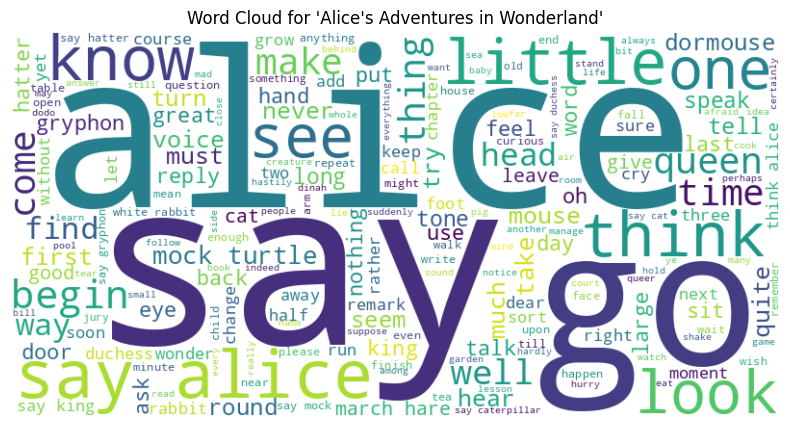

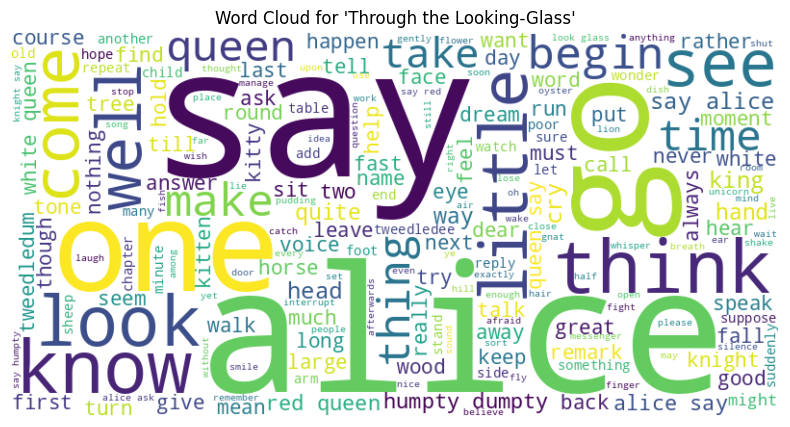

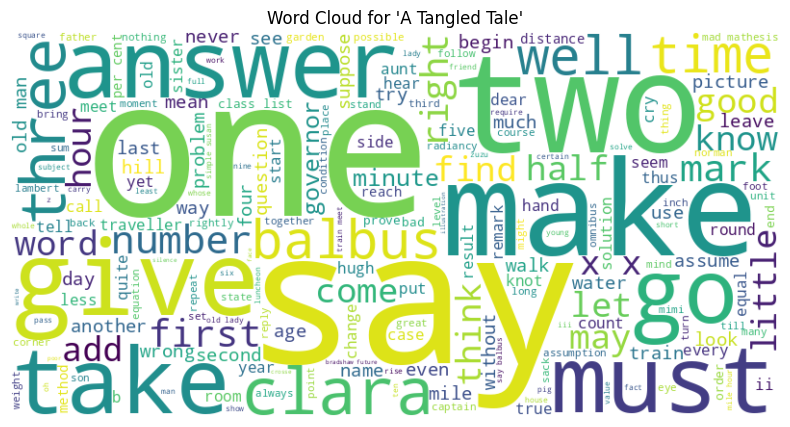

------------------------------


In [27]:
# Используем лемматизированный текст для WordCloud
print("\n--- Word Clouds for each book: ---")
for title, tokens in corpus_lemmatized_spacy.items(): # или corpus_no_stopwords.items()
    text_for_wordcloud = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for '{title}'")
    plt.show()
print("-" * 30)

2. BoW for 5 most frequent words

Which text is best? For BoW (and TF-IDF), to get the most meaningful words, it is best to use lemmatized text (or stemmed), after removing stop words. This ensures that "runs", "ran", "running" will be counted as one word "run", which will give a more accurate frequency. In this case, we use corpus_lemmatized_spacy.


--- Bag of Words: 5 Most Frequent Words in all books ---

Top 5 most frequent words (BoW, across all books):
[('say', 1310), ('alice', 870), ('one', 472), ('go', 437), ('get', 315)]

BoW Interpretation:
  - **Document number:** В данном случае, поскольку мы объединили все книги в один 'документ' (all_lemmas), то 'документ' один.
  - **Index:** BoW модель (как `CountVectorizer` в `sklearn`) создает числовой индекс для каждого уникального слова в словаре. Здесь мы используем `Counter`, который не создает индексы, а сразу выдает слово и его частоту.
  - **How many times the word was found:** Это второе число в каждой паре (например, ('alice', 497) -> 497 раз).
------------------------------


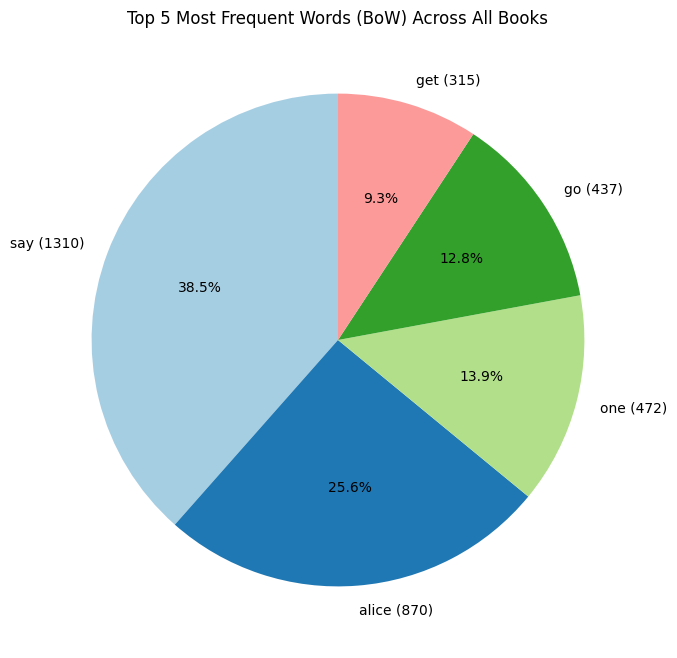


--- Анализ вывода BoW: ---
  - **Информативны ли эти слова?** Вероятно, нет. Вы увидите такие слова, как 'alice', 'said', 'little', 'king' и т.д. Хотя 'Alice' важна, 'said' или 'little' могут быть очень частыми, но не нести глубокой информации о *теме* книги, а скорее о стиле повествования.
  - **Ожидаемы ли они?** Да, очень ожидаемы. Имена главных героев, часто используемые глаголы или описания будут доминировать.
  - **Что это означает?** BoW не учитывает редкость слова во всем корпусе, поэтому очень частые слова (даже если они не стоп-слова) получают высокий вес, что может быть неинформативно.
------------------------------


In [28]:
print("\n--- Bag of Words: 5 Most Frequent Words in all books ---")

# Объединяем все лемматизированные токены из всех книг
all_lemmas = []
for title, tokens in corpus_lemmatized_spacy.items():
    all_lemmas.extend(tokens)

# Используем Counter для подсчета частоты слов
word_counts = Counter(all_lemmas)
most_common_words_bow = word_counts.most_common(5)

print("\nTop 5 most frequent words (BoW, across all books):")
print(most_common_words_bow)

# Анализ: "What is the document number? What is the index and what is how many times the word was found?"
print("\nBoW Interpretation:")
print("  - **Document number:** В данном случае, поскольку мы объединили все книги в один 'документ' (all_lemmas), то 'документ' один.")
print("  - **Index:** BoW модель (как `CountVectorizer` в `sklearn`) создает числовой индекс для каждого уникального слова в словаре. Здесь мы используем `Counter`, который не создает индексы, а сразу выдает слово и его частоту.")
print("  - **How many times the word was found:** Это второе число в каждой паре (например, ('alice', 497) -> 497 раз).")
print("-" * 30)

# 3. Pie plot of 5 most frequent words (BoW)
words_bow = [word for word, count in most_common_words_bow]
counts_bow = [count for word, count in most_common_words_bow]
labels_bow = [f"{word} ({count})" for word, count in most_common_words_bow]

plt.figure(figsize=(8, 8))
plt.pie(counts_bow, labels=labels_bow, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Top 5 Most Frequent Words (BoW) Across All Books")
plt.show()

# Анализ вывода BoW:
print("\n--- Анализ вывода BoW: ---")
print("  - **Информативны ли эти слова?** Вероятно, нет. Вы увидите такие слова, как 'alice', 'said', 'little', 'king' и т.д. Хотя 'Alice' важна, 'said' или 'little' могут быть очень частыми, но не нести глубокой информации о *теме* книги, а скорее о стиле повествования.")
print("  - **Ожидаемы ли они?** Да, очень ожидаемы. Имена главных героев, часто используемые глаголы или описания будут доминировать.")
print("  - **Что это означает?** BoW не учитывает редкость слова во всем корпусе, поэтому очень частые слова (даже если они не стоп-слова) получают высокий вес, что может быть неинформативно.")
print("-" * 30)

# **SUM**

--- Analyzing BoW output: ---
- **Are these words informative?** Probably not. You'll see words like 'alice', 'said', 'little', 'king', etc. While 'Alice' is important, 'said' or 'little' might be very common but not convey much information about the *topic* of the book, but rather about the style of the story.
- **Are they expected?** Yes, very expected. The names of the main characters, frequently used verbs, or descriptions will dominate.
- **What does this mean?** BoW doesn't take into account the rarity of a word in the entire corpus, so very common words (even if they are not stop words) are given a high weight, which may not be informative.
----------------------------

Solving the frequency problem using TF-IDF

Now let's apply TF-IDF to solve the problem of "too frequent but uninformative" words.


--- TF-IDF Analysis ---

Top 5 most relevant words (TF-IDF) for each book:

'Alice's Adventures in Wonderland':
  - gryphon: 0.3344
  - rabbit: 0.3222
  - turtle: 0.2867
  - hatter: 0.2636
  - mock: 0.2636

'Through the Looking-Glass':
  - dumpty: 0.3533
  - humpty: 0.3533
  - knight: 0.2927
  - tweedledum: 0.2335
  - tweedledee: 0.1830

'A Tangled Tale':
  - balbus: 0.3171
  - clara: 0.2849
  - train: 0.1852
  - governor: 0.1516
  - hugh: 0.1470

--- Pie Plots of 5 Most Relevant Words (TF-IDF) for each book ---


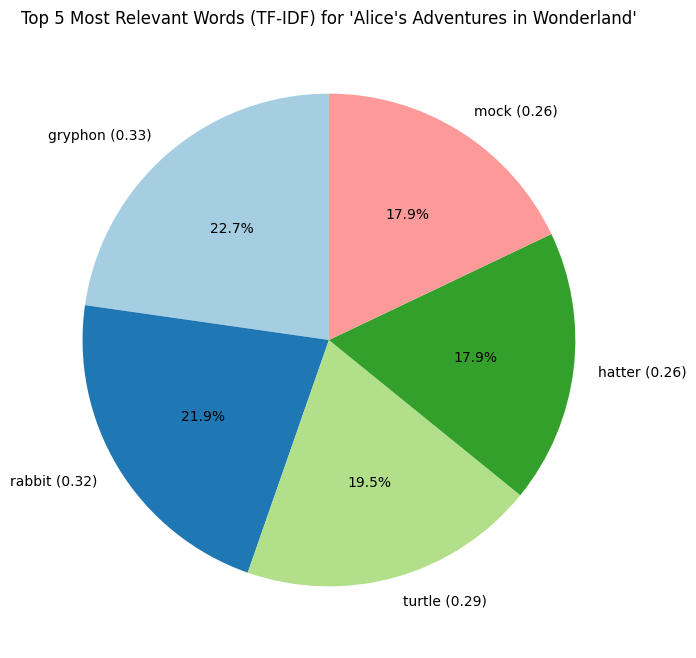

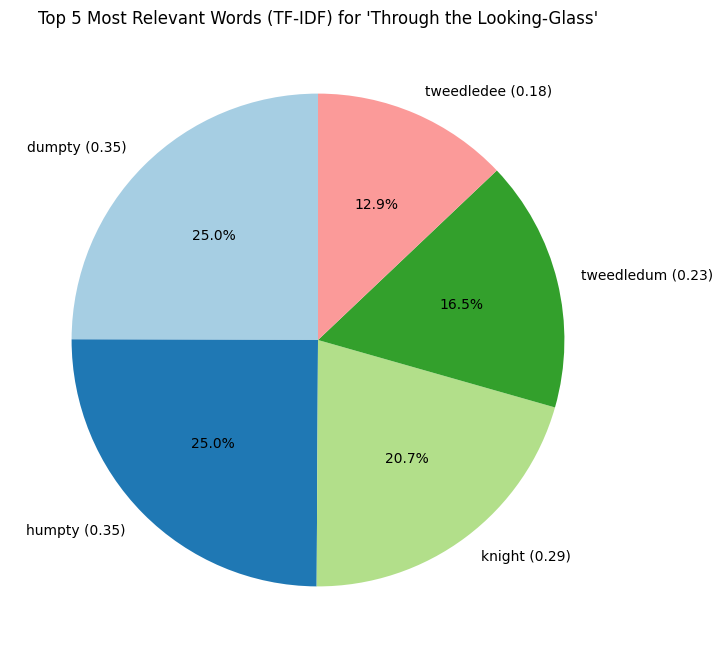

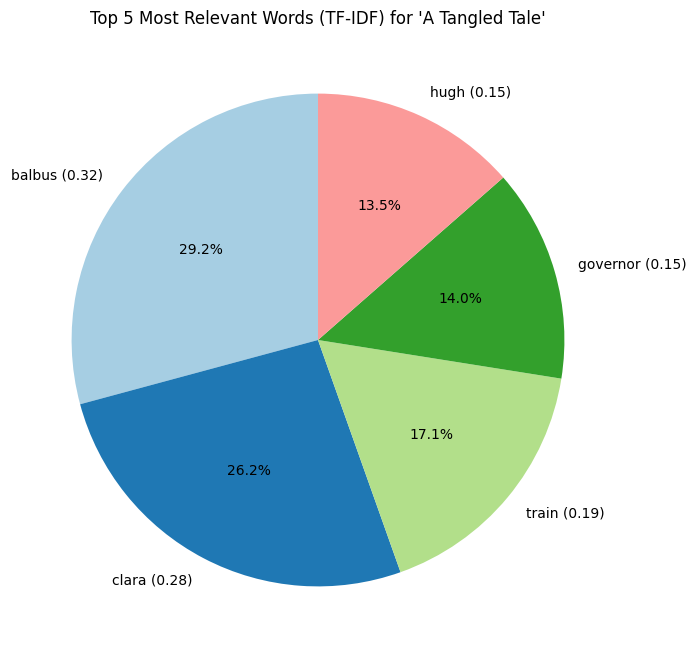


--- Анализ вывода TF-IDF: ---
  - **Информативны ли эти слова?** Скорее всего, да! Вы должны увидеть слова, которые являются уникальными или более характерными для конкретной книги, а не просто очень частыми в целом.
  - **Ожидаемы ли они?** Менее ожидаемы, чем в BoW, потому что TF-IDF выделяет 'специфичные' слова. Например, для 'Alice's Adventures in Wonderland' вы, возможно, увидите слова, связанные с конкретными персонажами или уникальными событиями этой книги, а не просто 'Alice' или 'said'.
  - **Что это означает?** TF-IDF эффективно решает проблему доминирования общих слов, позволяя нам сосредоточиться на терминах, которые действительно отличают один документ от других.
------------------------------


In [29]:
print("\n--- TF-IDF Analysis ---")

# Для TF-IDF нужен список строк (документов), где каждый элемент - это одна книга
# Объединяем лемматизированные токены каждой книги обратно в строку
corpus_lemmatized_str = {title: ' '.join(tokens) for title, tokens in corpus_lemmatized_spacy.items()}
documents = [corpus_lemmatized_str[title] for title in book_urls.keys()]
document_titles = list(book_urls.keys())

# Создаем TF-IDF векторизатор
# min_df=1: слово должно встречаться хотя бы в 1 документе (учитывать все слова)
# max_df=0.85: слово, встречающееся в более чем 85% документов, будет игнорироваться (чтобы убрать очень частые слова, как Alice, которая есть почти в каждой книге, но именно для TF-IDF, а не просто BoW)
# Для маленьких датасетов min_df/max_df нужно подбирать аккуратно
# min_df=1, max_df=2 (как в хинте) - это очень специфично.
# max_df=2 означает, что слово должно быть НЕ более чем в 2х документах.
# Это может быть слишком жестко для нашего корпуса из 3х книг.
# Я бы рекомендовал использовать float для max_df (например, 0.85) или оставить параметры по умолчанию,
# если хотите увидеть все слова.
# Давайте попробуем с max_df=0.85, чтобы увидеть эффект.
# Если использовать min_df=1, max_df=2:
# vectorizer_tfidf = TfidfVectorizer(min_df=1, max_df=2)
# Это означает, что будут учитываться только слова, которые встречаются минимум в 1 документе и максимум в 2 документах.
# Если Alice есть во всех 3х, она будет отфильтрована.

# Используем max_df=0.85, чтобы убрать очень частые слова. Или 0.6 для 3 документов (если > 2 из 3)
# Если хотим строго по хинту: min_df=1, max_df=2. Это исключит слова, которые есть во всех 3 книгах.
vectorizer_tfidf = TfidfVectorizer(min_df=1, max_df=2) # Согласно хинту
# vectorizer_tfidf = TfidfVectorizer(min_df=1, max_df=0.6) # Альтернатива для 3 документов (убирает слова, которые в 2+ книгах)


tfidf_matrix = vectorizer_tfidf.fit_transform(documents)
feature_names = vectorizer_tfidf.get_feature_names_out()

# Получаем TF-IDF матрицу
tfidf_array = tfidf_matrix.toarray()

# Находим 5 самых релевантных слов для КАЖДОГО документа
print("\nTop 5 most relevant words (TF-IDF) for each book:")
most_relevant_words_tfidf_per_doc = {}

for i, doc_title in enumerate(document_titles):
    # Получаем TF-IDF scores для текущего документа
    doc_scores = tfidf_array[i]
    # Создаем пары (слово, score)
    word_score_pairs = list(zip(feature_names, doc_scores))
    # Сортируем по score в убывающем порядке
    word_score_pairs.sort(key=lambda x: x[1], reverse=True)
    # Берем топ-5
    most_relevant_words_tfidf_per_doc[doc_title] = word_score_pairs[:5]

    print(f"\n'{doc_title}':")
    for word, score in most_relevant_words_tfidf_per_doc[doc_title]:
        print(f"  - {word}: {score:.4f}")

# Создаем круговые диаграммы для каждого документа
print("\n--- Pie Plots of 5 Most Relevant Words (TF-IDF) for each book ---")
for title, top_words_data in most_relevant_words_tfidf_per_doc.items():
    words = [word for word, score in top_words_data]
    scores = [score for word, score in top_words_data]
    labels = [f"{word} ({score:.2f})" for word, score in top_words_data]

    plt.figure(figsize=(8, 8))
    plt.pie(scores, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(f"Top 5 Most Relevant Words (TF-IDF) for '{title}'")
    plt.show()

# Анализ вывода TF-IDF:
print("\n--- Анализ вывода TF-IDF: ---")
print("  - **Информативны ли эти слова?** Скорее всего, да! Вы должны увидеть слова, которые являются уникальными или более характерными для конкретной книги, а не просто очень частыми в целом.")
print("  - **Ожидаемы ли они?** Менее ожидаемы, чем в BoW, потому что TF-IDF выделяет 'специфичные' слова. Например, для 'Alice's Adventures in Wonderland' вы, возможно, увидите слова, связанные с конкретными персонажами или уникальными событиями этой книги, а не просто 'Alice' или 'said'.")
print("  - **Что это означает?** TF-IDF эффективно решает проблему доминирования общих слов, позволяя нам сосредоточиться на терминах, которые действительно отличают один документ от других.")
print("-" * 30)